In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm
from einops import rearrange

import sys, os
sys.path.append("../") # important for relative imports to work

In [2]:
from utils.datamodule import CIFAR10Datamodule
from models.unet import BaseUNet
train_dm = CIFAR10Datamodule("data",batch_size=32, train = True)
val_dm = CIFAR10Datamodule("data",batch_size=32, train = False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


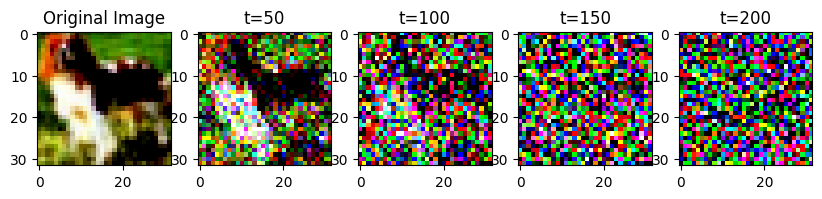

In [3]:
FORWARD_STEPS = 200
from train.beta_schedules import *
betas = cosine_beta_schedule(FORWARD_STEPS)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim = 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def forward_diffuse(x_0, t):
    """
    Perform the forward diffusion process, with:
    x0: input image of shape [B, C, H, W]
    t: input timesteps of shape [B]
    returns:
    x_t: noisy image at time step t of shape [B, C, H, W]
    noise: the generated gaussian noise
    """
    noise = torch.randn(x_0.shape, device = x_0.device) * sqrt_one_minus_alphas_cumprod[t]
    x_t = x_0 * sqrt_alphas_cumprod[t] + noise
    return x_t, noise

im = next(iter(train_dm.dataloader))[0][0]
im = im.unsqueeze(0)

ax, fig = plt.subplots(1, 5, figsize=(10, 5))
fig[0].imshow(im[0].permute(1, 2, 0))
fig[0].set_title("Original Image")
for i in range(1, 5):
    im, _ = forward_diffuse(im, i*50 - 1)
    fig[i].imshow(im[0].permute(1, 2, 0))
    fig[i].set_title(f"t={i*50}")

In [5]:
from models.unet import KarrasUNet
model = KarrasUNet(dim = 128)
epsilon_theta = model(im, torch.zeros(1))
assert epsilon_theta.shape == im.shape

time shape torch.Size([1])
